# Train a Production Model

The production model is used for model deployment. The production model could be shared with other researchers to predict on new data. When there is an updated version of the model input datasets or an updated major AMPL version, a new version of the production model should be created. 

We will use these functions to retrain a best model for production and compare the production model with the best model.

`create_prediction_pipeline_from_file` and
`train_model_from_tar`

In [1]:
import pandas as pd
import os
os.getcwd()

'/home/jupyter/hERG_Analysis'

In [2]:
# import packages 
import pandas as pd
import os
os.getcwd()
from atomsci.ddm.utils import model_retrain as mr
from atomsci.ddm.utils import model_version_utils as mv
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import predict_from_model as pfm
from atomsci.ddm.pipeline import perf_plots as pp
from sklearn.metrics import r2_score
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-05-07 17:42:53.762567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 17:42:56.766701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 17:42:56.766753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 17:42:56.782727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 17:42:58.257901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 17:42:58.262305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Start from saved best model
We're using the best performing model. Setting the production parameter to True will set production=True in the model params.

/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz

Retraining a model trains based on the saved model_metadata. If the model_params production is True, the params.previously_split will be ignored. This production split is not saved. create_prediction_pipeline_from_file will reload the saved model. The default model param sets production to False. The AMPL version is checked in case this is a saved model from a previous version of AMPL. The saved model AMPL version must match the installed major AMPL version in order to be used.

In [3]:
# best model path 
best_model_path='/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz'

#get installed AMPL version
print("installed AMPL version: " + str(mv.get_ampl_version()))

#get AMPL model version
print("best model AMPL version: " + str(mv.get_ampl_version_from_model(best_model_path)))

#load best model production params
best_model_pipe = mp.create_prediction_pipeline_from_file(params=None, reload_dir=None, model_path=best_model_path, model_type='best_model', featurization=None, verbose=False)

#show production is false
print("orig_params.production: " + str(best_model_pipe.orig_params.production))

INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz version = "1.6", AMPL version = "1.6"


installed AMPL version: 1.6.0
best model AMPL version: 1.6.0
num_model_tasks is deprecated and its value is ignored.
orig_params.production: False


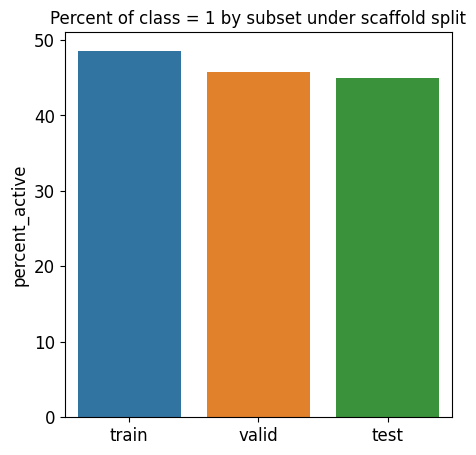

In [4]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : '/home/jupyter/hERG_Analysis/herg_chembl_curated.csv',
    "smiles_col" : "rdkit_smiles",
    "prediction_type": "classification",
    "response_cols" : "class",
    "split_uuid": '5f834022-46ac-4c7b-bca1-9573f6eb940f',
    "splitter": 'scaffold',
}
srdp.plot_split_subset_response_distrs(split_params)

The proportion of actives is fairly even across the split subsets. We will check later to see if the higher percentage of actives in the training set causes the model to predict too many false positives.

In [5]:
pp.plot_prec_recall_curve(best_model_pipe)

AttributeError: 'ModelPipeline' object has no attribute 'model_metadata'

In [6]:
pp.plot_roc_curve(best_model_pipe)

AttributeError: module 'atomsci.ddm.pipeline.perf_plots' has no attribute 'plot_roc_curve'

In [7]:
pp.plot_umap_feature_projections(best_model_path)

AttributeError: 'str' object has no attribute 'params'

num_model_tasks is deprecated and its value is ignored.


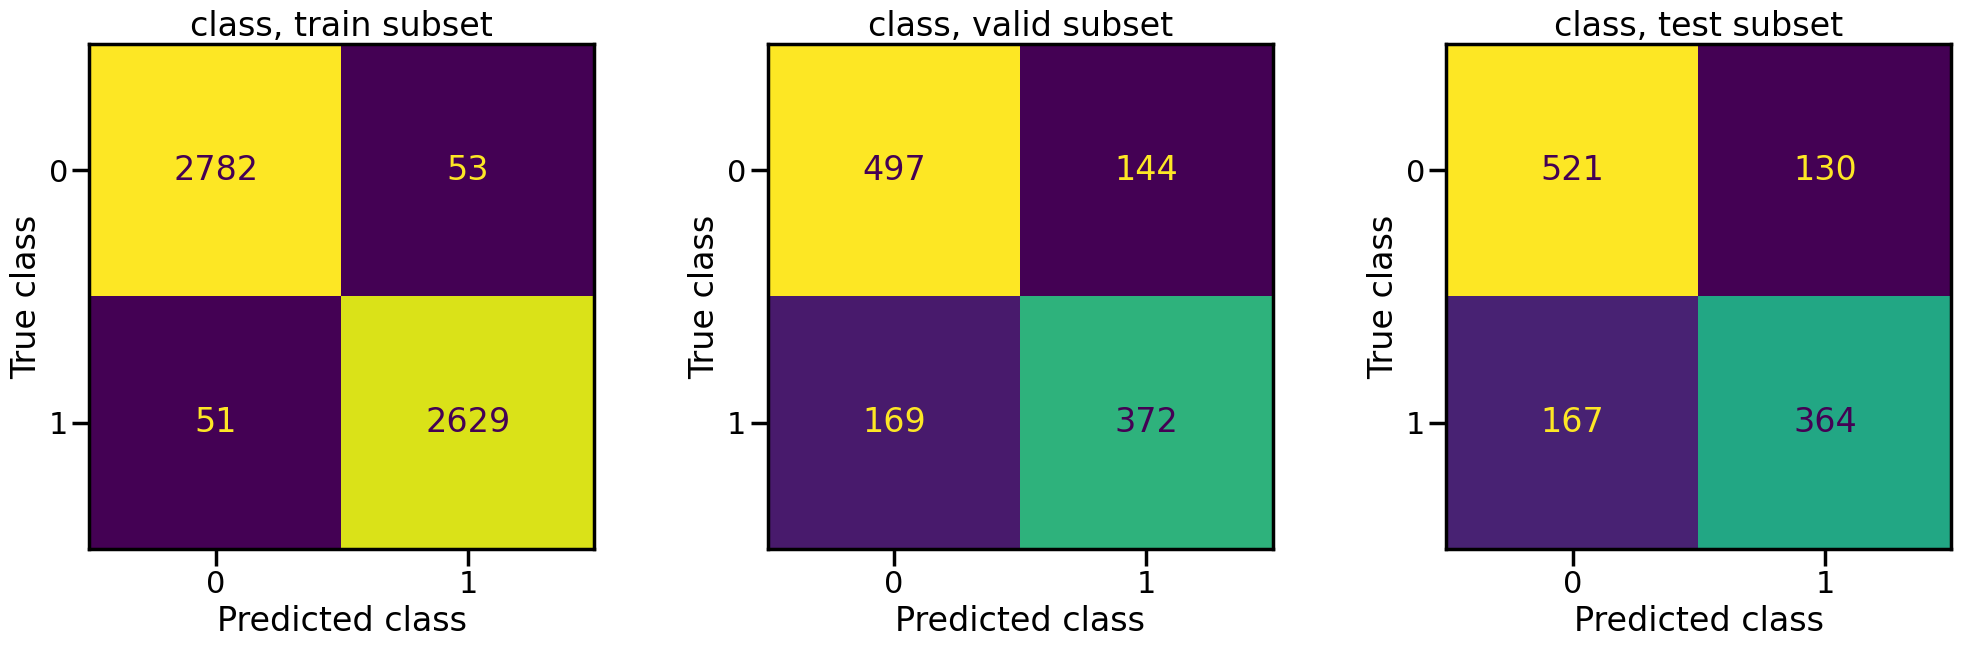

In [8]:
pp.plot_confusion_matrices(best_model_path)

num_model_tasks is deprecated and its value is ignored.


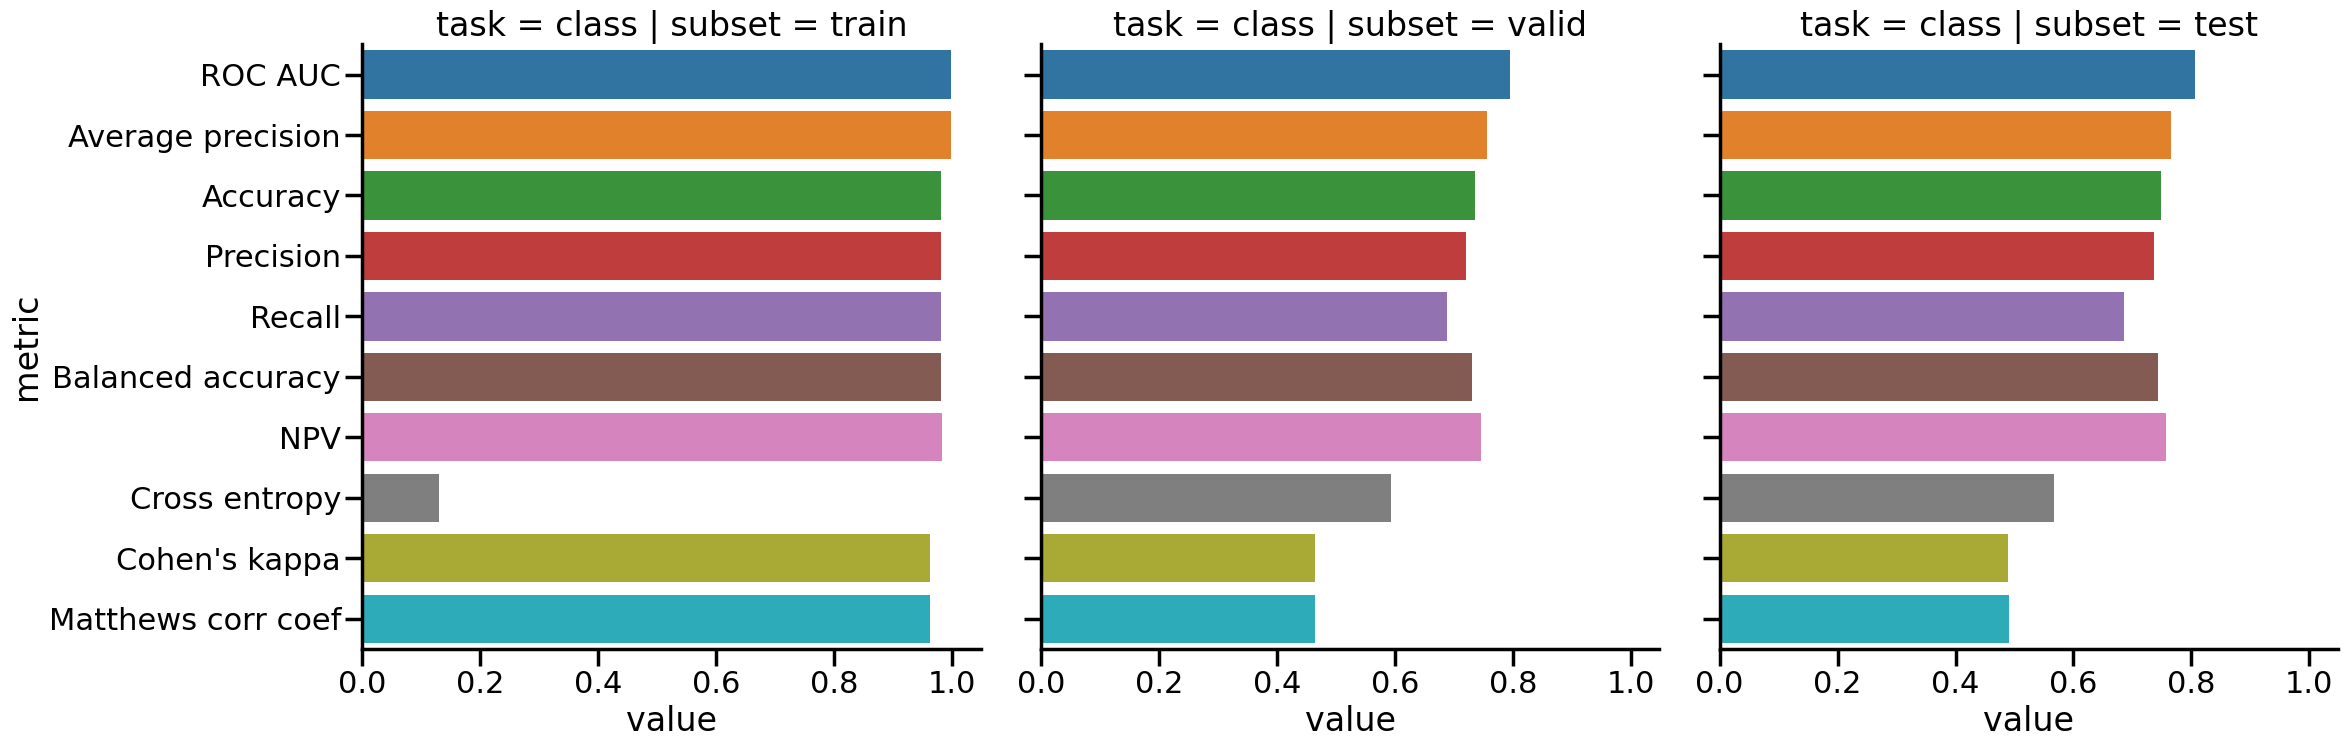

In [9]:
pp.plot_model_metrics(best_model_path, plot_size=8)

Retrain best model as production model
If the retrain production setting is False, the model will be retrained without changing any parameters. Note the production model's model parameter production is set to True.

In [10]:
odir='/home/jupyter/hERG_Analysis/Models'

production_model = mr.train_model_from_tar(input=best_model_path, output=odir, production=True)

num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
/home/jupyter/AMPL/atomsci160/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:48:51] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/jupyter/AMPL/atomsci160/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:48:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
print("production_model.params.production: " + str(production_model.params.production))
print("production_model.params.model_tarball_path: " + str(production_model.params.model_tarball_path))

print("production model AMPL version: " + str(mv.get_ampl_version_from_model(production_model.params.model_tarball_path)))

INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz, 1.6.0


production_model.params.production: True
production_model.params.model_tarball_path: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz
production model AMPL version: 1.6.0


## Load in test dataset

In [12]:
test_file_path = '/home/jupyter/hERG_Analysis/herg_central_curated.csv'
test_data = pd.read_csv(test_file_path)

test_data.head()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id
0,22416348,20.17528,30.99165,0.0,Cc1occc1C(=O)NCc1ccco1,ZSEHNDARAQYZIE-UHFFFAOYSA-N
1,26665387,10.22630,13.05888,0.0,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,SYQWJOODSYJNNZ-ZROIWOOFSA-N
2,862531,2.04420,0.06288,0.0,C[C@H](NC(=O)Nc1cccc(C(F)(F)F)c1)C(=O)O,DGYIEAKKNIJZMZ-LURJTMIESA-N
3,26732361,21.80250,17.87858,0.0,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,FTBAUYNAXYJVGK-UHFFFAOYSA-N
4,49735227,8.33980,19.03128,0.0,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,IOOKOVSIRAEBPQ-UHFFFAOYSA-N


# Creating models using subset of Compounds

### For 5000 compounds 

In [35]:
test_data_subset = test_data.sample(n=5000, random_state=42) 

In [36]:
test_data_subset.head()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id
141031,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N
98729,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N
83004,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N
45894,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N
3430,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N


In [37]:
test_data_subset.describe()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,2.789973e+07,6.183015,-2.928791,0.043600
std,1.811546e+07,10.914861,20.492813,0.204224
min,8.421730e+05,-89.770800,-90.992920,0.000000
25%,1.474173e+07,2.699125,-10.895020,0.000000
50%,2.480478e+07,8.140700,1.264730,0.000000
75%,4.966716e+07,12.373225,10.550005,0.000000
max,8.514917e+07,45.511000,71.897180,1.000000


we now predict hERG_inhib with the original best model:


In [38]:
id_col = 'compound_id'
smiles_col = 'rdkit_smiles'
response_col = 'hERG_inhib'

best_pred_df = pfm.predict_from_model_file(model_path = best_model_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
best_pred_df.head()

Standardizing SMILES strings for 5000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.652351,1
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.067347,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.117893,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.388250,0
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.132442,0


Now we'll run predictions on the same dataset with the production model:

In [39]:
prod_pred_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
prod_pred_df.head()

Standardizing SMILES strings for 5000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.460413,0
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.110192,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.298460,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.563846,1
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.050775,0


In [40]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Calculate the ROC-AUC score for the best model
best_roc_auc = np.round(roc_auc_score(best_pred_df.class_actual.values, best_pred_df.class_pred.values), 6)

# Calculate the ROC-AUC score for the production model
prod_roc_auc = np.round(roc_auc_score(prod_pred_df.class_actual.values, prod_pred_df.class_pred.values), 6)

# Print the ROC-AUC scores
print("Best model ROC-AUC score: " + str(best_roc_auc))
print("Production model ROC-AUC score: " + str(prod_roc_auc))

Best model ROC-AUC score: 0.688277
Production model ROC-AUC score: 0.672856


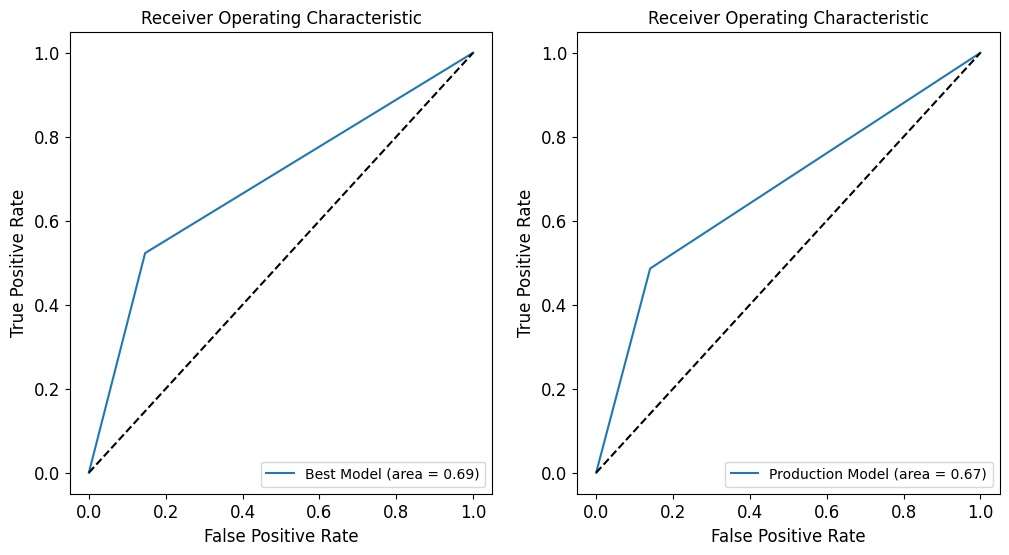

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(df, ax, label=None):
    fpr, tpr, _ = roc_curve(df['class_actual'].values, df['class_pred'].values)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Assuming 'actual' and 'predictions' are the columns in best_pred_df and prod_pred_df
plot_roc_curve(best_pred_df, ax[0], 'Best Model')
plot_roc_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

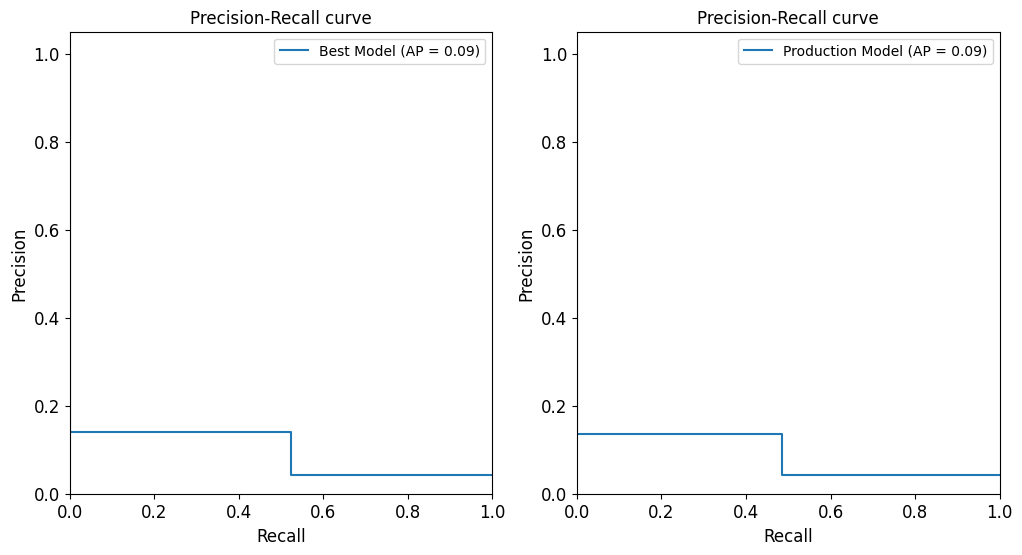

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(df, ax, label=None):
    precision, recall, _ = precision_recall_curve(df['class_actual'].values, df['class_pred'].values)
    avg_prec = average_precision_score(df['class_actual'].values, df['class_pred'].values)
    ax.step(recall, precision, where='post', label=f'{label} (AP = {avg_prec:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve')
    ax.legend(loc="upper right")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_precision_recall_curve(best_pred_df, ax[0], 'Best Model')
plot_precision_recall_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

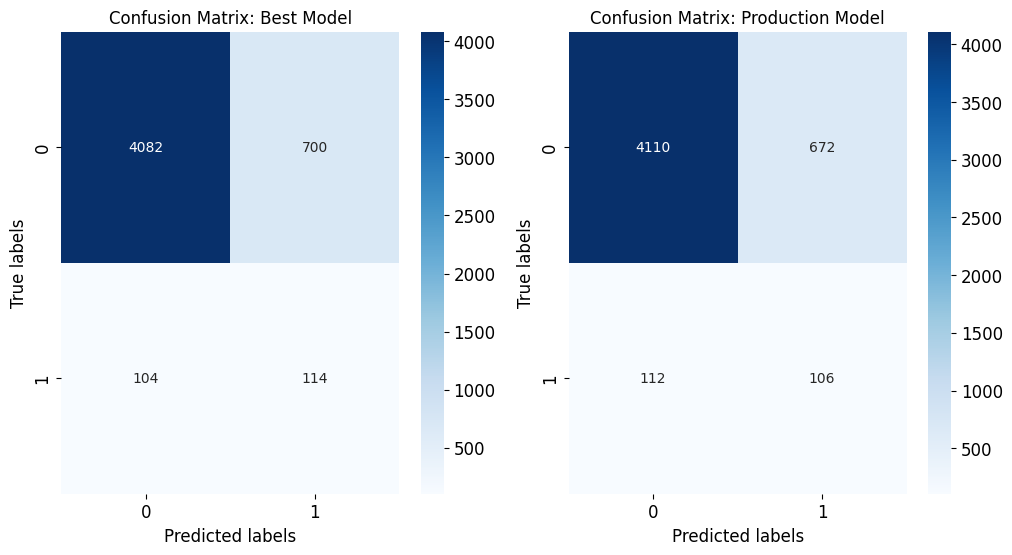

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(df, ax, label=None):
    cm = confusion_matrix(df['class_actual'], df['class_pred'].round())  # Assuming predictions are probabilities
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix: {label}')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_confusion_matrix(best_pred_df, ax[0], 'Best Model')
plot_confusion_matrix(prod_pred_df, ax[1], 'Production Model')

plt.show()

### For 10000 compounds

In [44]:
test_data_subset = test_data.sample(n=10000, random_state=42) 

In [45]:
test_data_subset.head()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id
141031,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N
98729,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N
83004,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N
45894,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N
3430,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N


In [46]:
test_data_subset.describe()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib
count,1.000000e+04,9999.000000,9999.000000,9999.000000
mean,2.805479e+07,6.251734,-2.842911,0.042304
std,1.811496e+07,10.941417,20.478753,0.201292
min,8.421730e+05,-101.575200,-158.042020,0.000000
25%,1.474200e+07,2.674650,-10.822670,0.000000
50%,2.480460e+07,8.190800,1.434780,0.000000
75%,4.966905e+07,12.410100,10.570880,0.000000
max,8.514917e+07,52.511200,101.747180,1.000000


we now predict hERG_inhib with the original best model:


In [47]:
id_col = 'compound_id'
smiles_col = 'rdkit_smiles'
response_col = 'hERG_inhib'

best_pred_df = pfm.predict_from_model_file(model_path = best_model_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
best_pred_df.head()

Standardizing SMILES strings for 10000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz version = "1.6", AMPL version = "1.6"


Could not parse 1 SMILES strings; will predict on the remainder.
num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.652351,1
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.067347,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.117893,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.388250,0
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.132442,0


Now we'll run predictions on the same dataset with the production model:

In [48]:
prod_pred_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
prod_pred_df.head()

Standardizing SMILES strings for 10000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz version = "1.6", AMPL version = "1.6"


Could not parse 1 SMILES strings; will predict on the remainder.
num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.460413,0
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.110192,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.298460,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.563846,1
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.050775,0


In [49]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Calculate the ROC-AUC score for the best model
best_roc_auc = np.round(roc_auc_score(best_pred_df.class_actual.values, best_pred_df.class_pred.values), 6)

# Calculate the ROC-AUC score for the production model
prod_roc_auc = np.round(roc_auc_score(prod_pred_df.class_actual.values, prod_pred_df.class_pred.values), 6)

# Print the ROC-AUC scores
print("Best model ROC-AUC score: " + str(best_roc_auc))
print("Production model ROC-AUC score: " + str(prod_roc_auc))

Best model ROC-AUC score: 0.688287
Production model ROC-AUC score: 0.686117


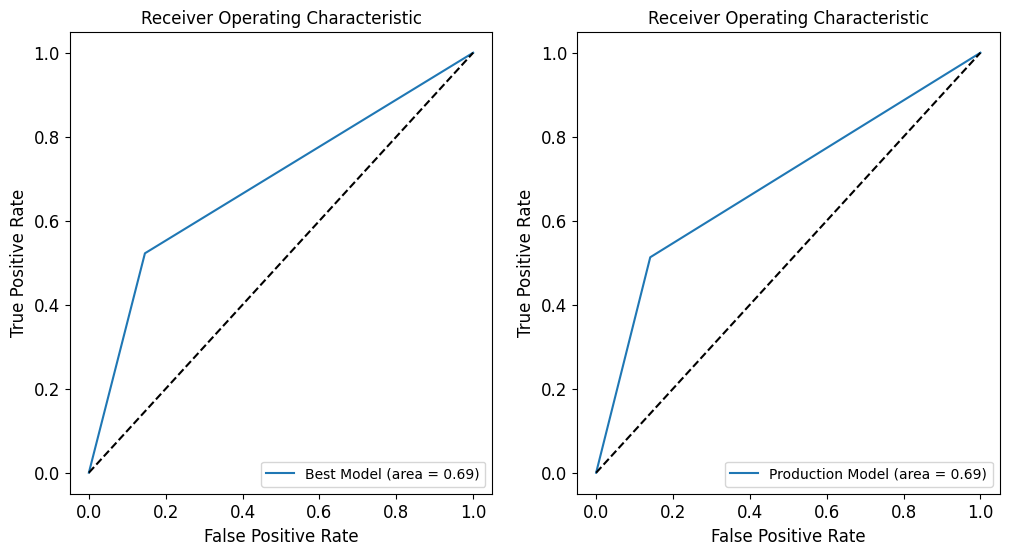

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(df, ax, label=None):
    fpr, tpr, _ = roc_curve(df['class_actual'].values, df['class_pred'].values)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Assuming 'actual' and 'predictions' are the columns in best_pred_df and prod_pred_df
plot_roc_curve(best_pred_df, ax[0], 'Best Model')
plot_roc_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

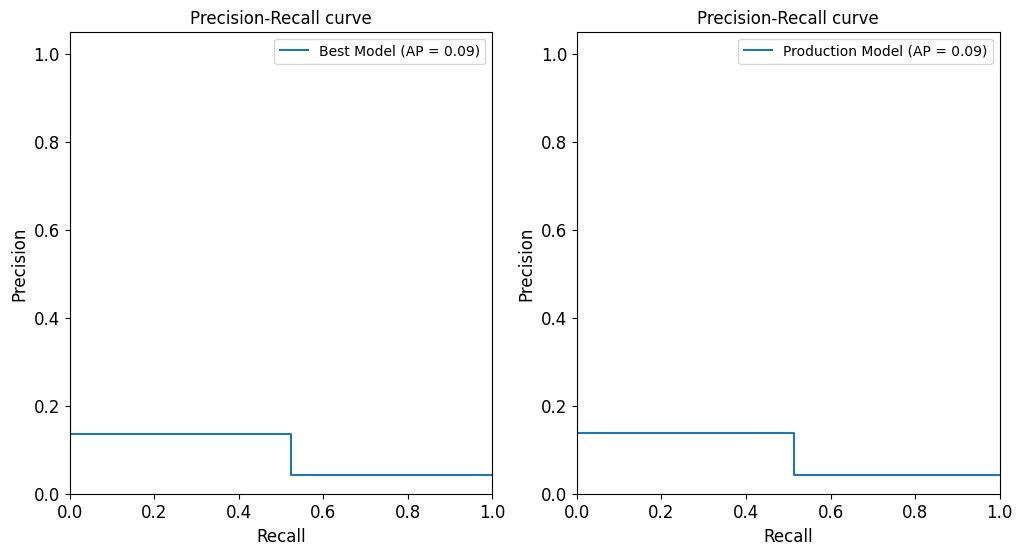

In [51]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(df, ax, label=None):
    precision, recall, _ = precision_recall_curve(df['class_actual'].values, df['class_pred'].values)
    avg_prec = average_precision_score(df['class_actual'].values, df['class_pred'].values)
    ax.step(recall, precision, where='post', label=f'{label} (AP = {avg_prec:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve')
    ax.legend(loc="upper right")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_precision_recall_curve(best_pred_df, ax[0], 'Best Model')
plot_precision_recall_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

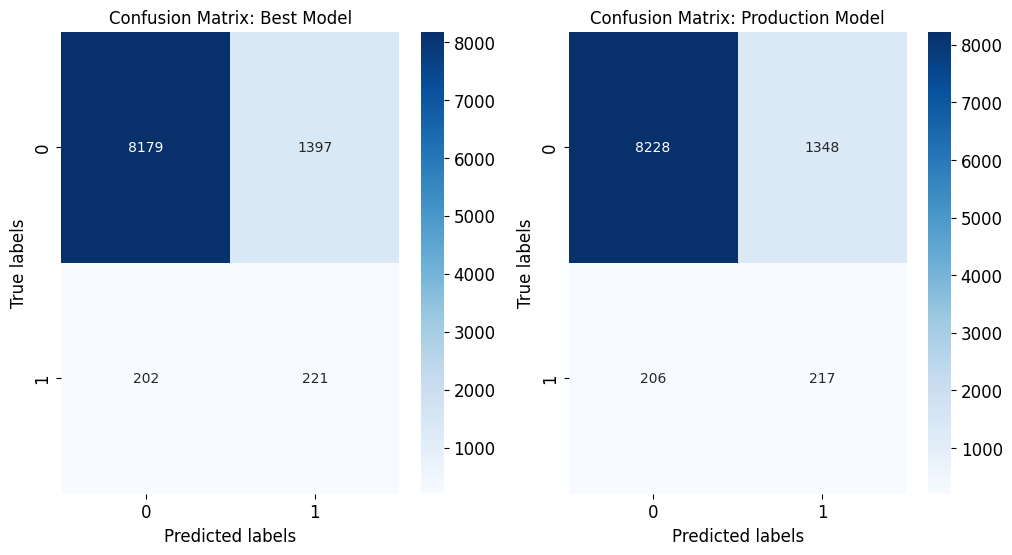

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(df, ax, label=None):
    cm = confusion_matrix(df['class_actual'], df['class_pred'].round())  # Assuming predictions are probabilities
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix: {label}')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_confusion_matrix(best_pred_df, ax[0], 'Best Model')
plot_confusion_matrix(prod_pred_df, ax[1], 'Production Model')

plt.show()

### For 30000 compounds

In [53]:
test_data_subset = test_data.sample(n=30000, random_state=42) 

In [54]:
test_data_subset.head()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id
141031,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N
98729,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N
83004,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N
45894,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N
3430,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N


In [55]:
test_data_subset.describe()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib
count,3.000000e+04,29999.000000,29999.000000,29999.000000
mean,2.805271e+07,6.255562,-2.811940,0.044468
std,1.804246e+07,11.108444,20.589078,0.206136
min,8.421230e+05,-299.017000,-283.822420,0.000000
25%,1.474246e+07,2.771300,-10.449720,0.000000
50%,2.480488e+07,8.241400,1.627380,0.000000
75%,4.966742e+07,12.428100,10.541630,0.000000
max,8.514917e+07,68.388000,101.747180,1.000000


we now predict hERG_inhib with the original best model:


In [56]:
id_col = 'compound_id'
smiles_col = 'rdkit_smiles'
response_col = 'hERG_inhib'

best_pred_df = pfm.predict_from_model_file(model_path = best_model_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
best_pred_df.head()

Standardizing SMILES strings for 30000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz version = "1.6", AMPL version = "1.6"


Could not parse 1 SMILES strings; will predict on the remainder.
num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.652351,1
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.067347,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.117893,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.388250,0
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.132442,0


Now we'll run predictions on the same dataset with the production model:

In [57]:
prod_pred_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
prod_pred_df.head()

Standardizing SMILES strings for 30000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz version = "1.6", AMPL version = "1.6"


Could not parse 1 SMILES strings; will predict on the remainder.
num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.460413,0
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.110192,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.298460,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.563846,1
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.050775,0


In [58]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Calculate the ROC-AUC score for the best model
best_roc_auc = np.round(roc_auc_score(best_pred_df.class_actual.values, best_pred_df.class_pred.values), 6)

# Calculate the ROC-AUC score for the production model
prod_roc_auc = np.round(roc_auc_score(prod_pred_df.class_actual.values, prod_pred_df.class_pred.values), 6)

# Print the ROC-AUC scores
print("Best model ROC-AUC score: " + str(best_roc_auc))
print("Production model ROC-AUC score: " + str(prod_roc_auc))

Best model ROC-AUC score: 0.679503
Production model ROC-AUC score: 0.680752


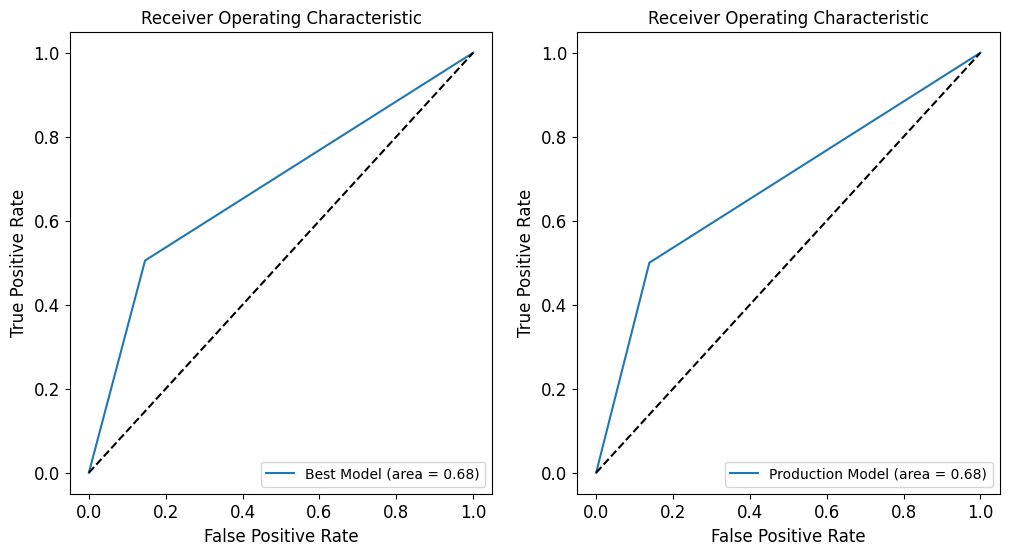

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(df, ax, label=None):
    fpr, tpr, _ = roc_curve(df['class_actual'].values, df['class_pred'].values)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Assuming 'actual' and 'predictions' are the columns in best_pred_df and prod_pred_df
plot_roc_curve(best_pred_df, ax[0], 'Best Model')
plot_roc_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

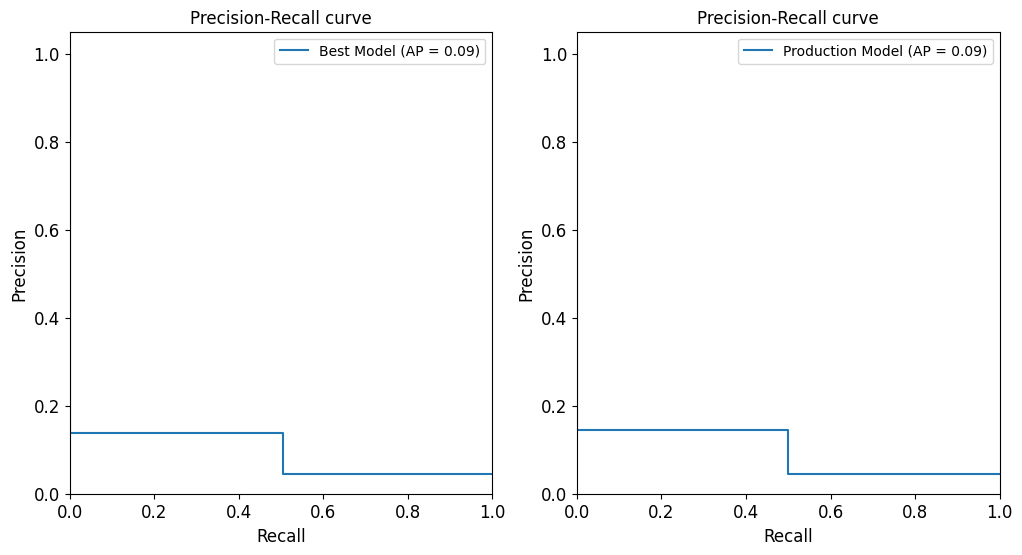

In [60]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(df, ax, label=None):
    precision, recall, _ = precision_recall_curve(df['class_actual'].values, df['class_pred'].values)
    avg_prec = average_precision_score(df['class_actual'].values, df['class_pred'].values)
    ax.step(recall, precision, where='post', label=f'{label} (AP = {avg_prec:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve')
    ax.legend(loc="upper right")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_precision_recall_curve(best_pred_df, ax[0], 'Best Model')
plot_precision_recall_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

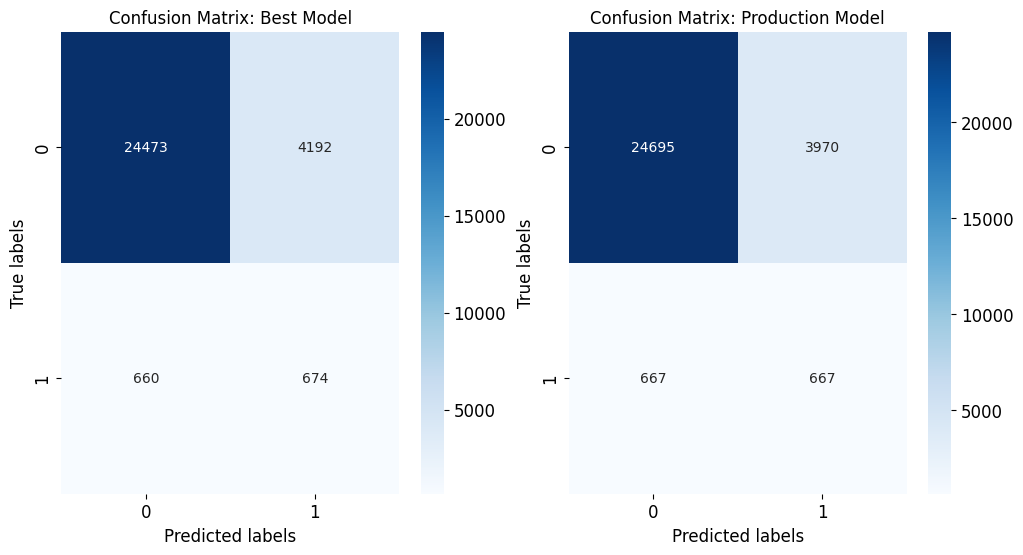

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(df, ax, label=None):
    cm = confusion_matrix(df['class_actual'], df['class_pred'].round())  # Assuming predictions are probabilities
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix: {label}')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_confusion_matrix(best_pred_df, ax[0], 'Best Model')
plot_confusion_matrix(prod_pred_df, ax[1], 'Production Model')

plt.show()

### For 60000 compounds

In [62]:
test_data_subset = test_data.sample(n=60000, random_state=42) 

In [63]:
test_data_subset.head()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id
141031,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N
98729,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N
83004,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N
45894,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N
3430,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N


In [64]:
test_data_subset.describe()

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib
count,6.000000e+04,59999.000000,59999.000000,59999.000000
mean,2.807241e+07,6.204196,-2.864814,0.045567
std,1.807704e+07,11.277329,20.656910,0.208547
min,8.421230e+05,-299.017000,-283.822420,0.000000
25%,1.474223e+07,2.767150,-10.362720,0.000000
50%,2.480534e+07,8.230000,1.593380,0.000000
75%,4.966694e+07,12.395150,10.491180,0.000000
max,8.514917e+07,126.489200,213.104180,1.000000


we now predict hERG_inhib with the original best model:


In [ ]:
id_col = 'compound_id'
smiles_col = 'rdkit_smiles'
response_col = 'hERG_inhib'

best_pred_df = pfm.predict_from_model_file(model_path = best_model_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
best_pred_df.head()

Standardizing SMILES strings for 60000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_989fa91a-32c6-4e04-a1d8-b59ab94c8d53.tar.gz version = "1.6", AMPL version = "1.6"


Could not parse 1 SMILES strings; will predict on the remainder.
num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.652351,1
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.067347,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.117893,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.388250,0
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.132442,0


Now we'll run predictions on the same dataset with the production model:

In [ ]:
prod_pred_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = test_data_subset,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
prod_pred_df.head()

Standardizing SMILES strings for 60000 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_f00f58a7-b2a3-4ed7-aa14-46ea94687215.tar.gz version = "1.6", AMPL version = "1.6"


Could not parse 1 SMILES strings; will predict on the remainder.
num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_smiles_feat_df[col] = calc_desc_df[col]
/home/jupyter/AMPL/atomsci/ddm/pipeline/featurization.py:1714: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,ID,hERG_at_1uM,hERG_at_10uM,hERG_inhib,rdkit_smiles,compound_id,orig_smiles,class_actual,class_prob,class_pred
0,7965799,-16.6360,-52.27472,1.0,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,VUCDJDCQYKWNHE-UHFFFAOYSA-N,Cc1ccccc1C1CC(c2ccc(Br)cc2)Nc2nc(N)nn21,1.0,0.460413,0
1,24797085,8.9510,1.49958,0.0,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,IDFKAZZRWRKHIJ-UHFFFAOYSA-N,COc1ccc(-n2c(-c3ccco3)nc3ccccc3c2=O)cc1,0.0,0.110192,0
2,14729003,0.9262,1.83678,0.0,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,ILRBYLNWMLZZKG-UHFFFAOYSA-N,CC1CN=C(N(C(=O)Nc2ccccc2)c2ccc(F)cc2)S1,0.0,0.298460,0
3,4259507,2.0190,-21.08842,0.0,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,JEDHRYKEQVUCHX-UHFFFAOYSA-N,O=C(CN1CC(c2ccccc2)CC1=O)OCc1ccccc1F,0.0,0.563846,1
4,4257872,9.6563,-3.81412,0.0,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,OVKAHFHFOMUZMI-UHFFFAOYSA-N,Cn1c(=O)c2c(nc(Oc3ccc(-c4ccccc4)cc3)n2C)n(C)c1=O,0.0,0.050775,0


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Calculate the ROC-AUC score for the best model
best_roc_auc = np.round(roc_auc_score(best_pred_df.class_actual.values, best_pred_df.class_pred.values), 6)

# Calculate the ROC-AUC score for the production model
prod_roc_auc = np.round(roc_auc_score(prod_pred_df.class_actual.values, prod_pred_df.class_pred.values), 6)

# Print the ROC-AUC scores
print("Best model ROC-AUC score: " + str(best_roc_auc))
print("Production model ROC-AUC score: " + str(prod_roc_auc))

Best model ROC-AUC score: 0.672147
Production model ROC-AUC score: 0.673549


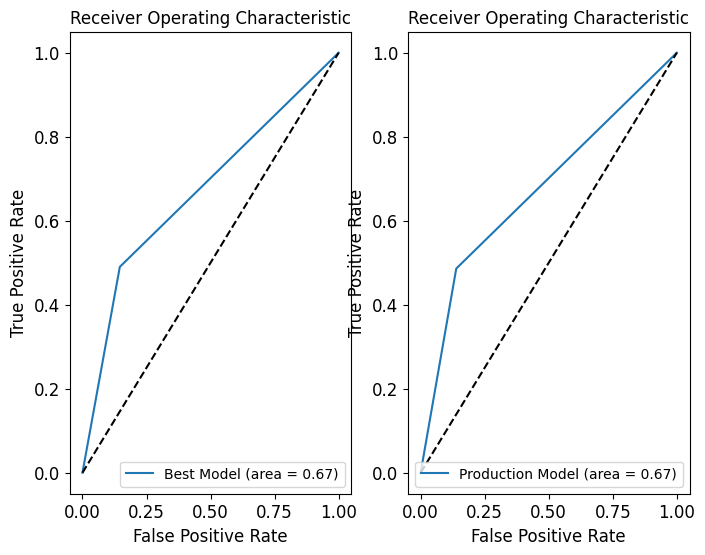

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(df, ax, label=None):
    fpr, tpr, _ = roc_curve(df['class_actual'].values, df['class_pred'].values)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")

fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# Assuming 'actual' and 'predictions' are the columns in best_pred_df and prod_pred_df
plot_roc_curve(best_pred_df, ax[0], 'Best Model')
plot_roc_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

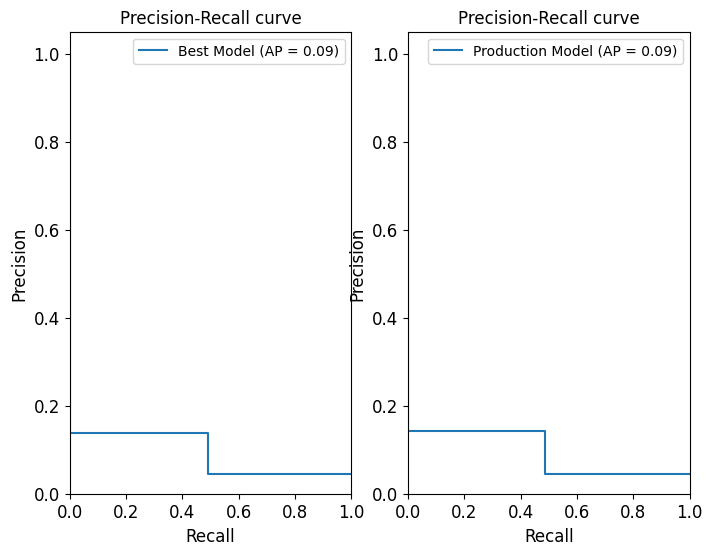

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(df, ax, label=None):
    precision, recall, _ = precision_recall_curve(df['class_actual'].values, df['class_pred'].values)
    avg_prec = average_precision_score(df['class_actual'].values, df['class_pred'].values)
    ax.step(recall, precision, where='post', label=f'{label} (AP = {avg_prec:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve')
    ax.legend(loc="upper right")

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
plot_precision_recall_curve(best_pred_df, ax[0], 'Best Model')
plot_precision_recall_curve(prod_pred_df, ax[1], 'Production Model')

plt.show()

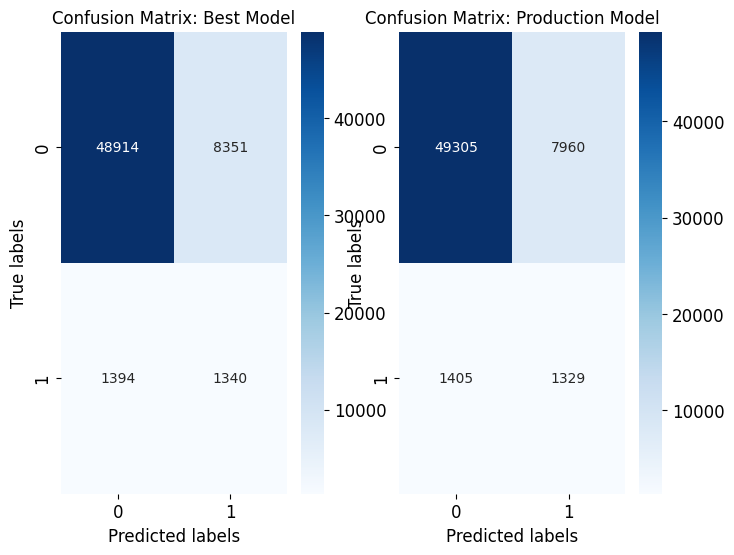

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(df, ax, label=None):
    cm = confusion_matrix(df['class_actual'], df['class_pred'].round())  # Assuming predictions are probabilities
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix: {label}')

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
plot_confusion_matrix(best_pred_df, ax[0], 'Best Model')
plot_confusion_matrix(prod_pred_df, ax[1], 'Production Model')

plt.show()